In [20]:
import osmnx as ox
ox.config(log_console = True, data_folder = 'data')
graph = ox.load_graphml('nerails_with_pop.graphml')

In [2]:
import numpy as np
import networkx as nx
import scipy.sparse
import scipy.sparse.csgraph
import pandas as pd
import collections

In [50]:
# https://github.com/gboeing/osmnx-examples/blob/master/notebooks/08-example-line-graph.ipynb

def plot_graph(series, G, cmap='inferno'):
    df = pd.DataFrame(data=pd.Series(series).sort_values(), columns=['cc'])
    df['colors'] = ox.get_colors(n=len(df), cmap=cmap, start=0.2)
    df = df.reindex(graph.nodes())
    nc = df['colors'].tolist()
    fig, ax = ox.plot_graph(G, bgcolor='w', node_color=nc, node_edgecolor='none', node_zorder=2, node_size=25,
                            edge_linewidth=0.2, edge_alpha=1, fig_height=20)

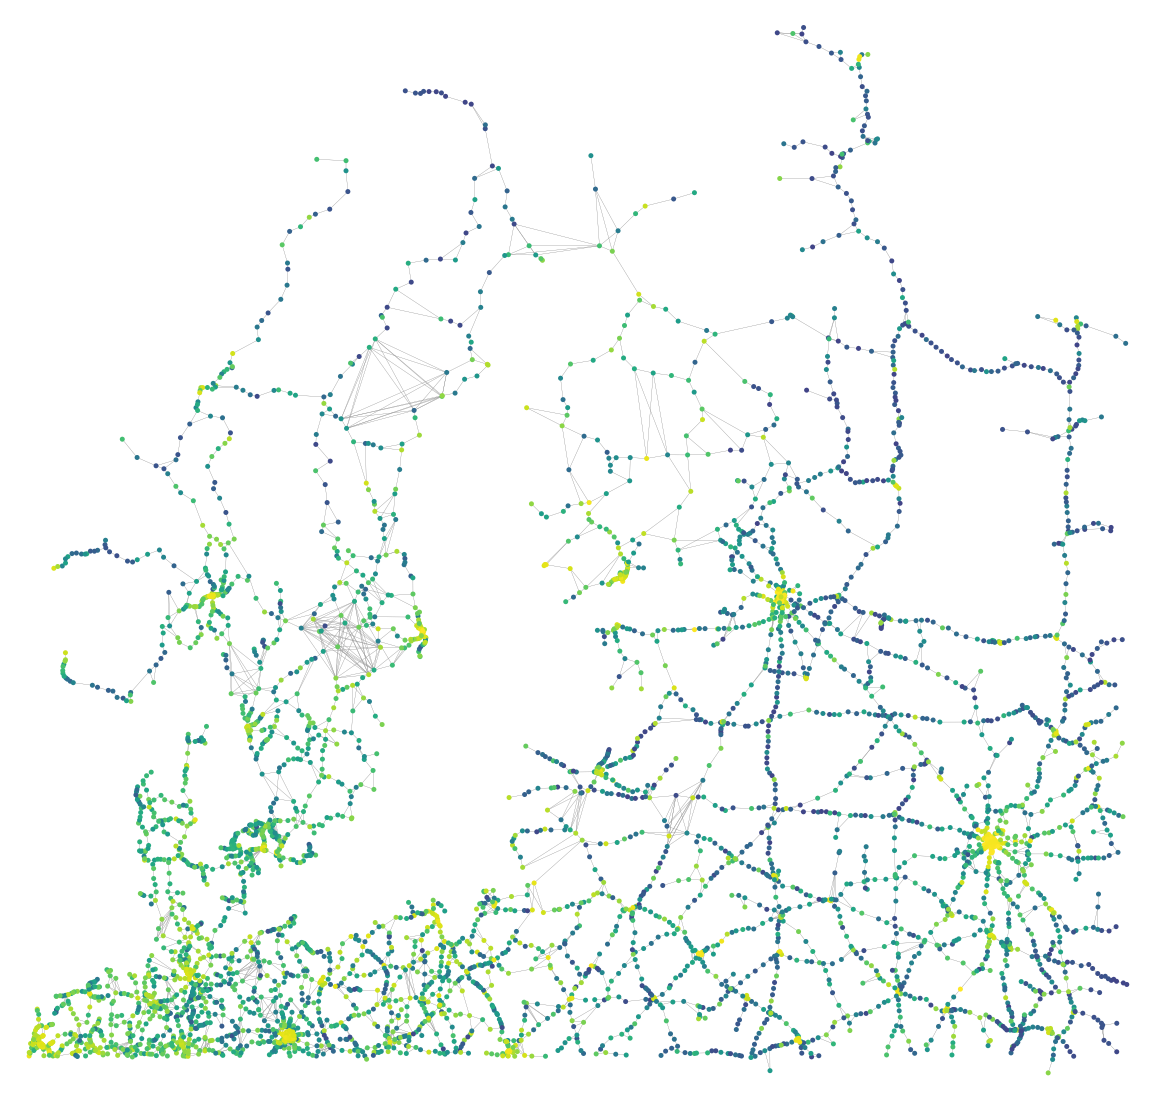

In [51]:
df = pd.DataFrame.from_dict(dict(graph.nodes), orient='index', columns=['population'])
df = df.astype(float)

plot_graph(dict(df.population), graph, cmap='viridis')

In [4]:
# Takes a fucking lifetime
# extended_graph_stats = ox.extended_stats(graph, connectivity=True, anc=True, ecc=True, bc=True, cc=True)
extended_graph_stats = ox.extended_stats(graph, ecc=True, bc=True, cc=True)
# ^even this takes about 10 minutes

In [5]:
print(extended_graph_stats.keys())

dict_keys(['avg_neighbor_degree', 'avg_neighbor_degree_avg', 'avg_weighted_neighbor_degree', 'avg_weighted_neighbor_degree_avg', 'degree_centrality', 'degree_centrality_avg', 'clustering_coefficient', 'clustering_coefficient_avg', 'clustering_coefficient_weighted', 'clustering_coefficient_weighted_avg', 'pagerank', 'pagerank_max_node', 'pagerank_max', 'pagerank_min_node', 'pagerank_min', 'eccentricity', 'diameter', 'radius', 'center', 'periphery', 'closeness_centrality', 'closeness_centrality_avg', 'betweenness_centrality', 'betweenness_centrality_avg'])


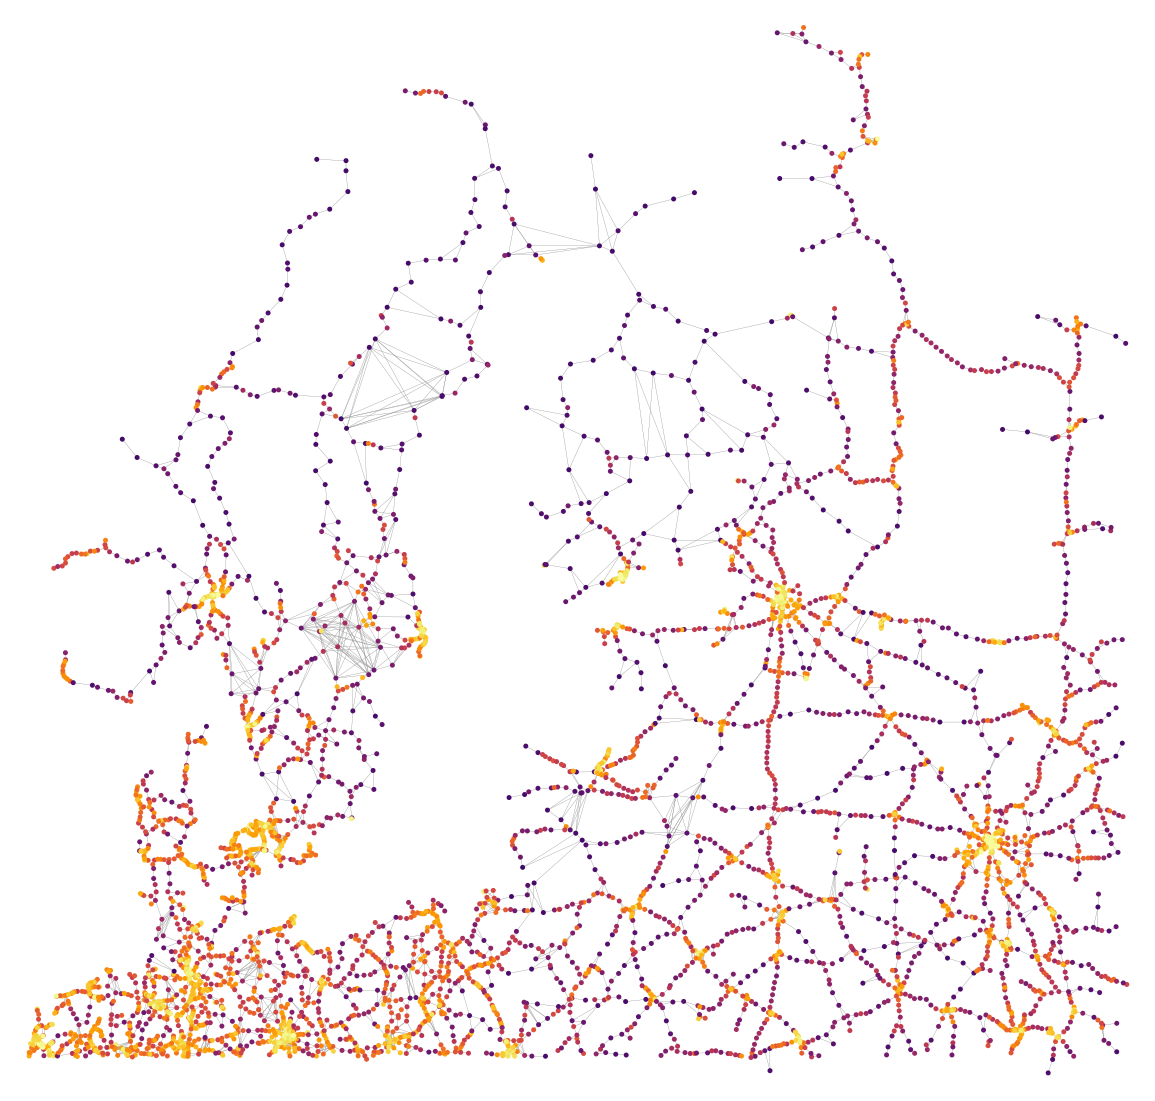

In [52]:
plot_graph(extended_graph_stats['avg_weighted_neighbor_degree'], graph)

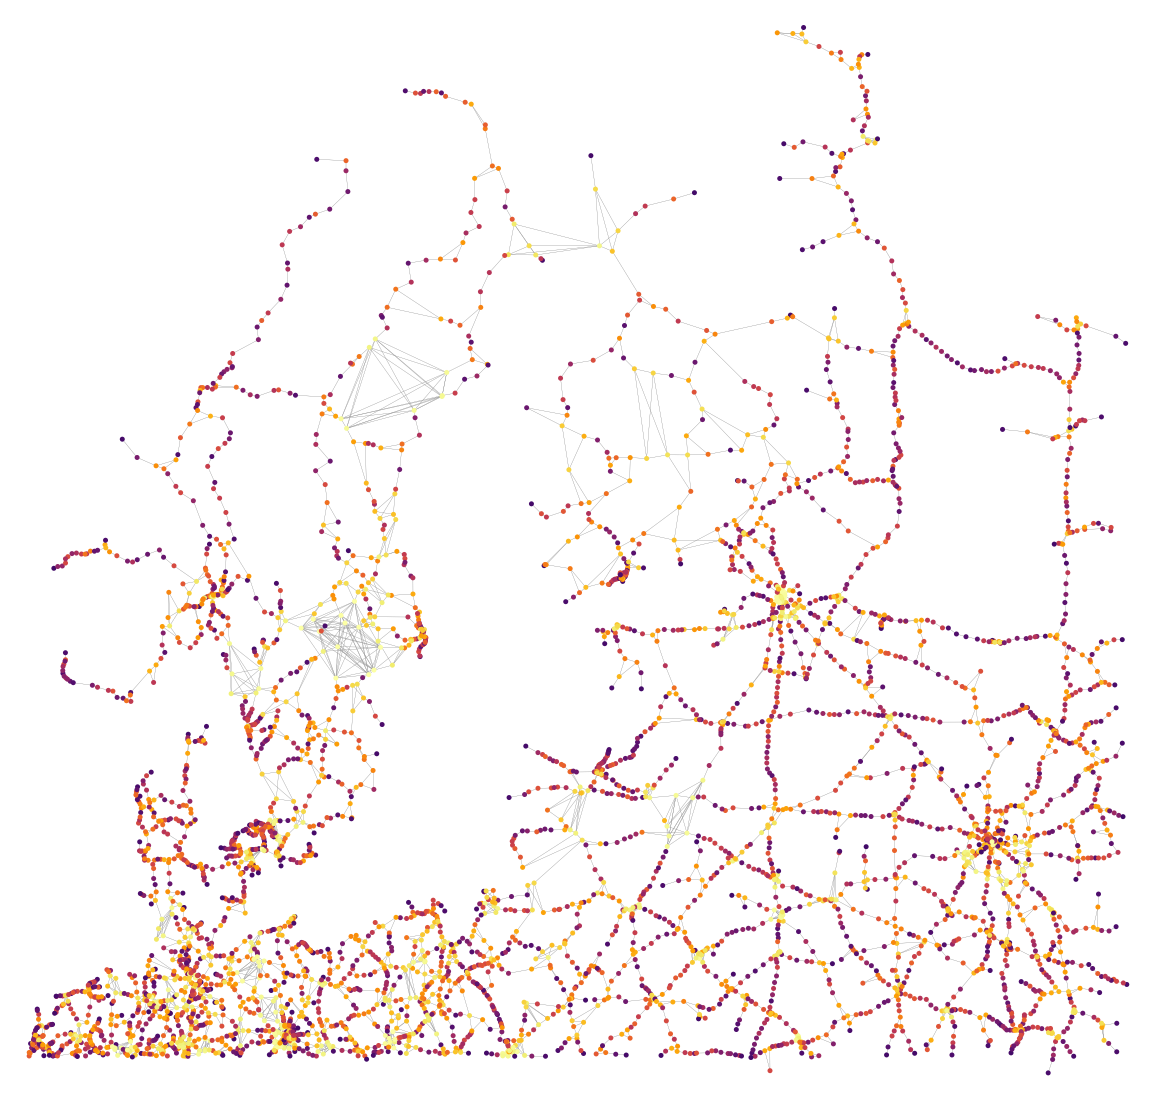

In [53]:
plot_graph(extended_graph_stats['degree_centrality'], graph)

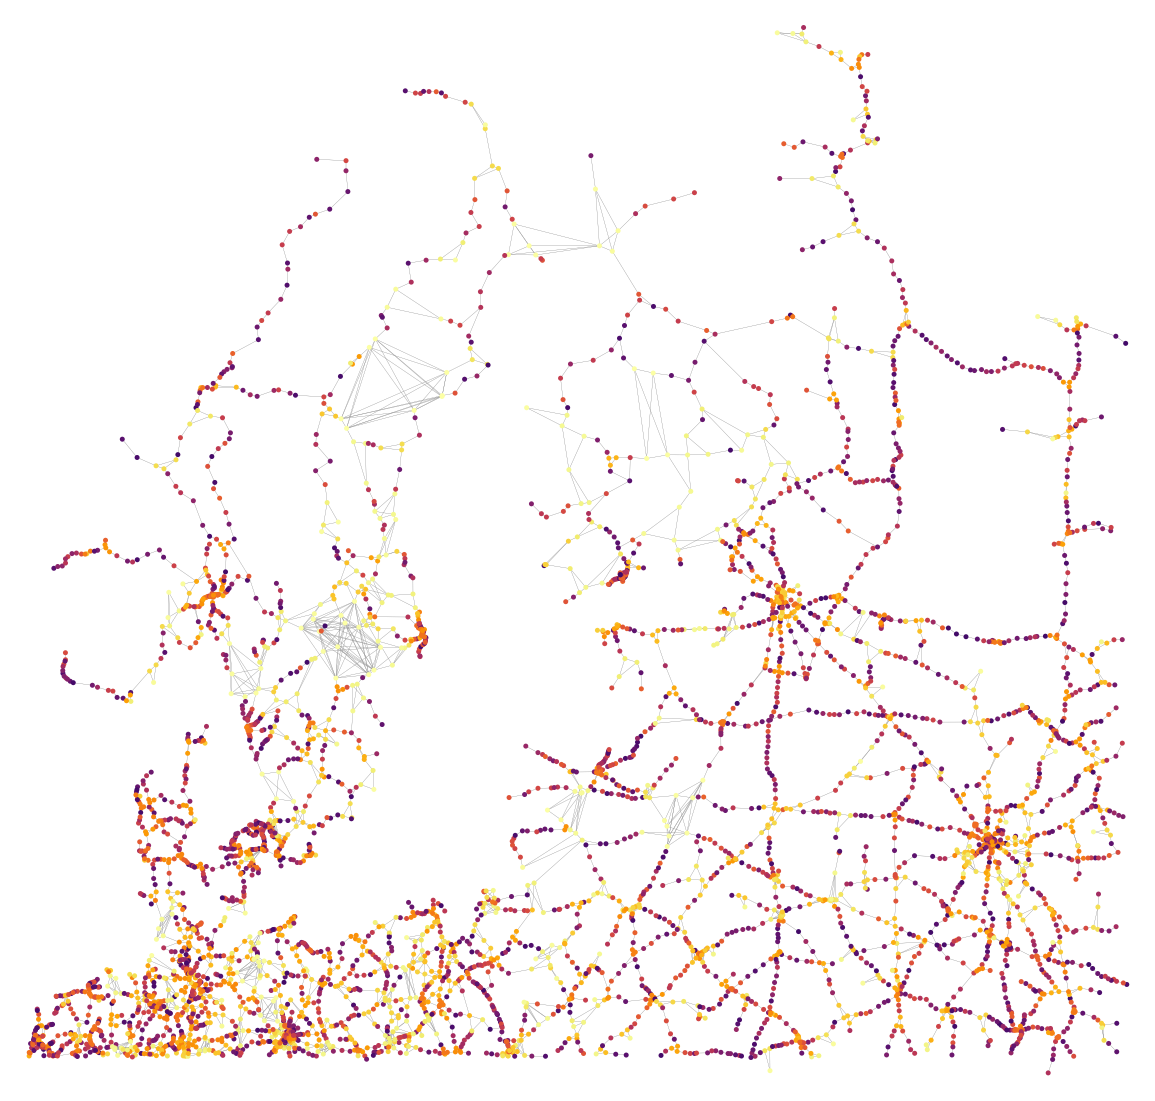

In [54]:
plot_graph(extended_graph_stats['clustering_coefficient_weighted'], graph)

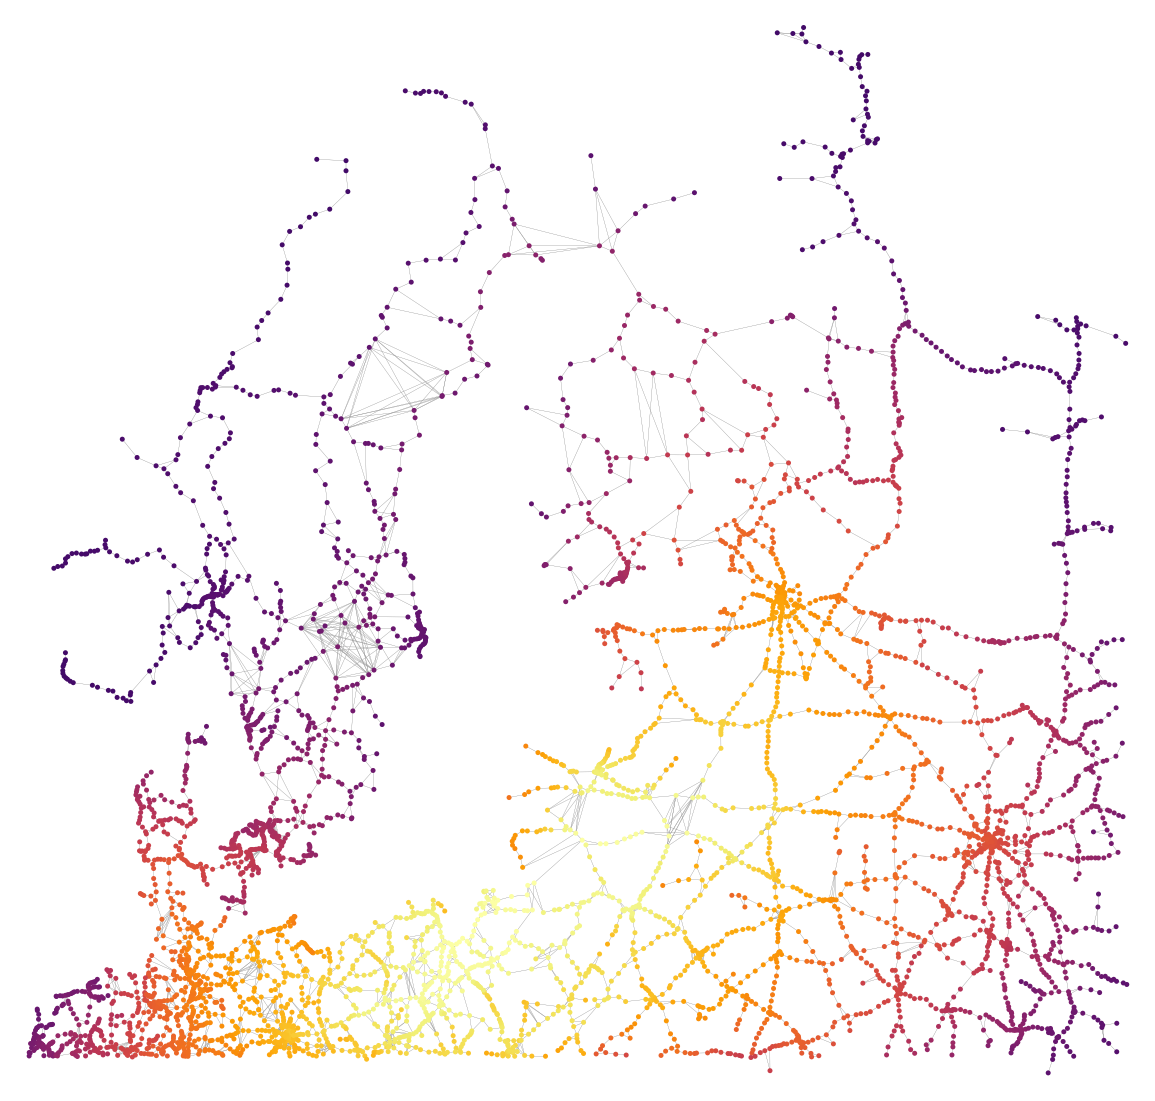

In [56]:
plot_graph(extended_graph_stats['closeness_centrality'], graph)

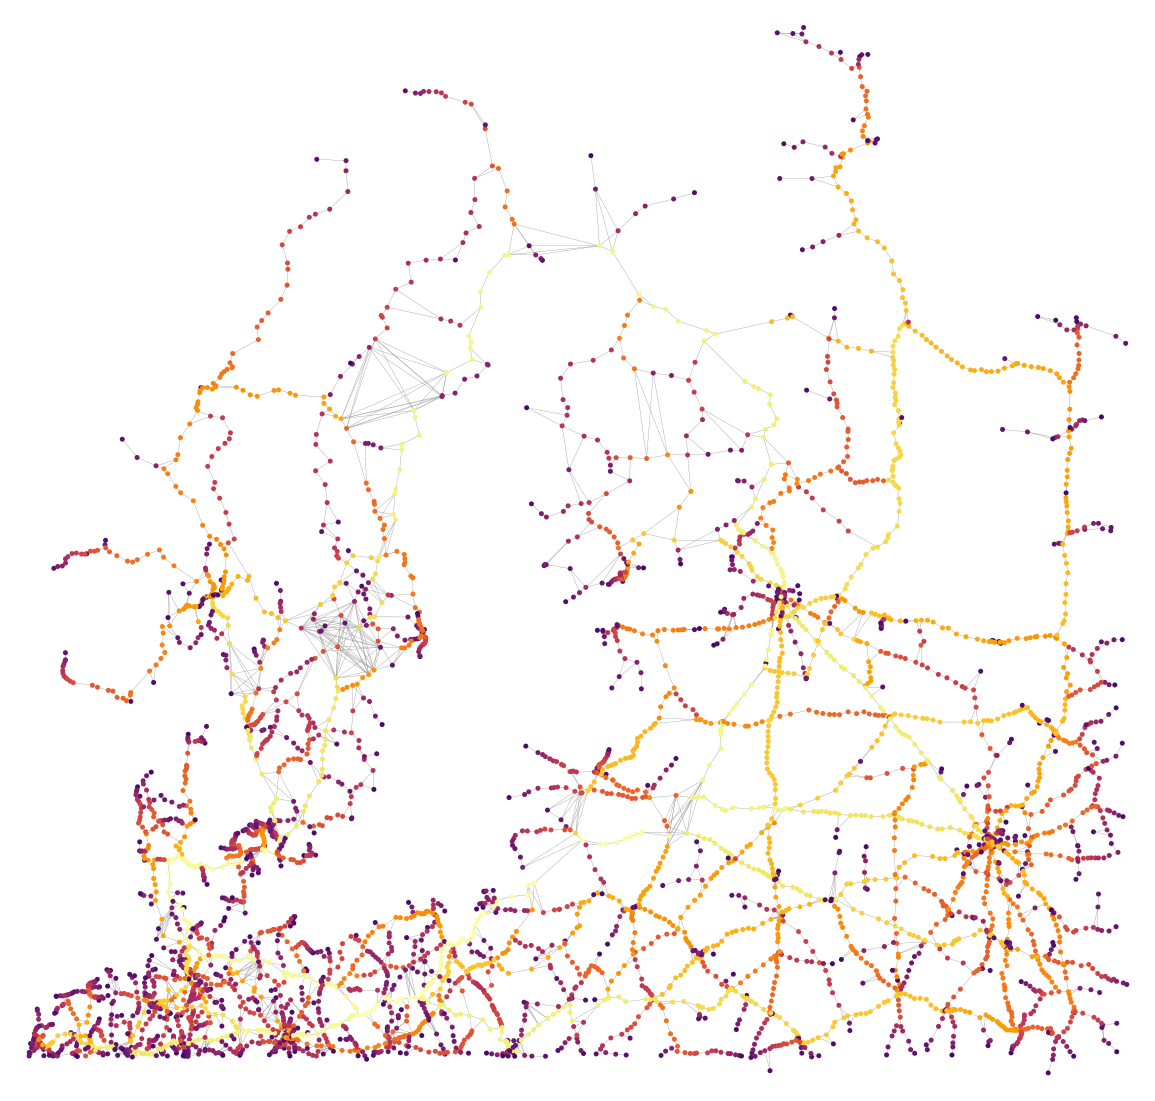

In [55]:
plot_graph(extended_graph_stats['betweenness_centrality'], graph)

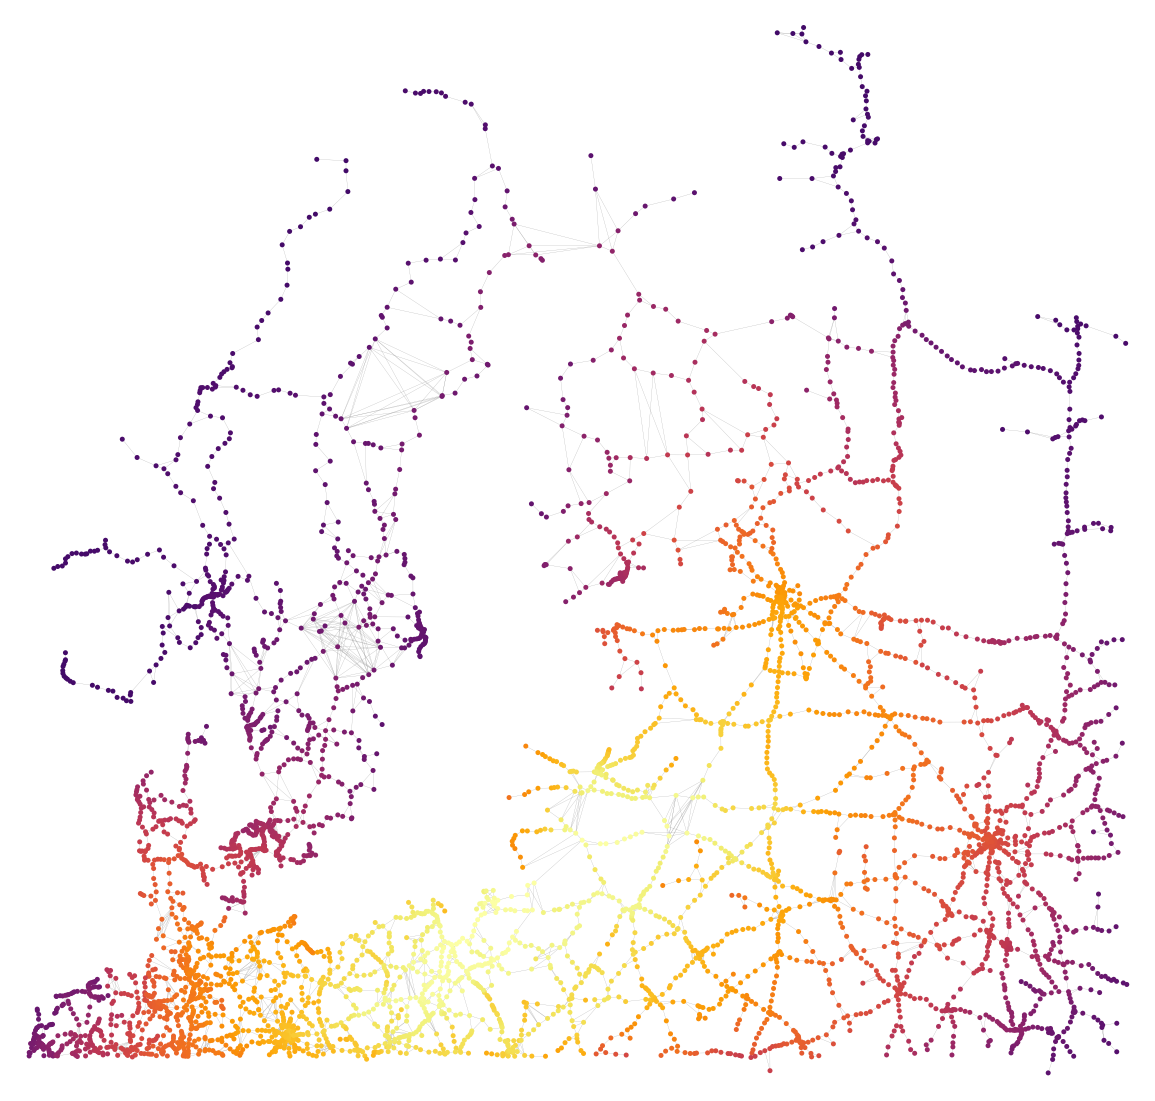

In [57]:
# Here we have weighted closeness centrality, networkx is super slow to produce one
# Source: https://medium.com/@pasdan/closeness-centrality-via-networkx-is-taking-too-long-1a58e648f5ce

# Might actually be useless now since the same graph can be found above, networkx got a lot
# faster after deleting self loops. Could be beneficial in larger graphs though.

graph = graph.to_undirected()

A = nx.adjacency_matrix(graph, nodelist=None, weight='length').tolil()
D = scipy.sparse.csgraph.floyd_warshall(A, directed=False, unweighted=False)

n = D.shape[0]
closeness_centrality = {}
for r in range(0, n):
    
    cc = 0.0
    
    possible_paths = list(enumerate(D[r, :]))
    shortest_paths = dict(filter( \
        lambda x: not x[1] == np.inf, possible_paths))
    
    total = sum(shortest_paths.values())
    n_shortest_paths = len(shortest_paths) - 1.0
    if total > 0.0 and n > 1:
        s = n_shortest_paths / (n - 1)
        cc = (n_shortest_paths / total) * s
    closeness_centrality[list(graph.nodes)[r]] = cc
    
graph.to_directed()

plot_graph(closeness_centrality, graph)